Import all the Dependencies

In [ ]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
from IPython.display import HTML
import numpy as np

Set all the Constants

In [ ]:
BATCH_SIZE = 32
IMAGE_SIZE = 256
CHANNELS=3
EPOCHS=70

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Import data into tensorflow dataset object


In [ ]:
directory = '/content/drive/My Drive/TB_Chest_Radiography_Database'

In [ ]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    directory,
    seed=123,
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 3396 files belonging to 2 classes.


In [ ]:
len(dataset)

107

In [ ]:
class_names = dataset.class_names
class_names

['Normal', 'Tuberculosis']

In [ ]:
for image_batch, labels_batch in dataset.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy())

(32, 256, 256, 3)
[1 0 0 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 1 0 1 0 1 0 1]


Visualize some of the images from our dataset

In [ ]:
plt.figure(figsize=(10, 10))
for image_batch, labels_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4,i + 1 )
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")


Function to Split Dataset

In [ ]:
len(dataset)

107

In [ ]:
train_size = 0.8
len(dataset)*train_size

85.60000000000001

In [ ]:
train_ds = dataset.take(85)
len(train_ds)

85

In [ ]:
test_ds = dataset.skip(85)
len(test_ds)

22

In [ ]:
val_size=0.1
len(dataset)*val_size

10.700000000000001

In [ ]:
val_ds = test_ds.take(10)
len(val_ds)

10

In [ ]:
test_ds = test_ds.skip(10)
len(test_ds)

12

In [ ]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [ ]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [ ]:
np.array([len(train_ds),len(val_ds),len(test_ds)])

array([85, 10, 12])

Cache, Shuffle, and Prefetch the Dataset

In [ ]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

Building the Model

In [ ]:
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  layers.experimental.preprocessing.Rescaling(1./255),
])

In [ ]:
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
    
])

In [ ]:
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

Model Architecture

In [ ]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 2

model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)

Compiling the Model

In [ ]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [ ]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=70,
)

Epoch 1/70
85/85 [==============================] - 47s 537ms/step - loss: 0.4000 - accuracy: 0.8600 - val_loss: 0.3192 - val_accuracy: 0.9062
Epoch 2/70
85/85 [==============================] - 43s 505ms/step - loss: 0.5177 - accuracy: 0.8091 - val_loss: 0.4603 - val_accuracy: 0.8125
Epoch 3/70
85/85 [==============================] - 44s 509ms/step - loss: 0.4784 - accuracy: 0.8024 - val_loss: 0.4484 - val_accuracy: 0.8125
Epoch 4/70
85/85 [==============================] - 44s 510ms/step - loss: 0.4624 - accuracy: 0.8027 - val_loss: 0.4319 - val_accuracy: 0.8156
Epoch 5/70
85/85 [==============================] - 44s 511ms/step - loss: 0.4379 - accuracy: 0.8061 - val_loss: 0.3689 - val_accuracy: 0.8125
Epoch 6/70
85/85 [==============================] - 44s 513ms/step - loss: 0.3900 - accuracy: 0.8366 - val_loss: 0.3730 - val_accuracy: 0.8625
Epoch 7/70
85/85 [==============================] - 44s 513ms/step - loss: 0.2929 - accuracy: 0.8759 - val_loss: 0.2975 - val_accuracy: 0.8562

In [ ]:
scores = model.evaluate(test_ds)

12/12 [==============================] - 3s 78ms/step - loss: 0.1267 - accuracy: 0.9609


In [ ]:
scores

[0.1267293095588684, 0.9609375]

Plotting the Accuracy and Loss Curves

In [ ]:
history

In [ ]:
history.params

{'epochs': 70, 'steps': 85, 'verbose': 1}

In [ ]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [ ]:
type(history.history['loss'])

list

In [ ]:
len(history.history['loss'])

70

In [ ]:
history.history['loss'][:5] 

[0.40003708004951477,
 0.5176593661308289,
 0.478423535823822,
 0.46237993240356445,
 0.4378502368927002]

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

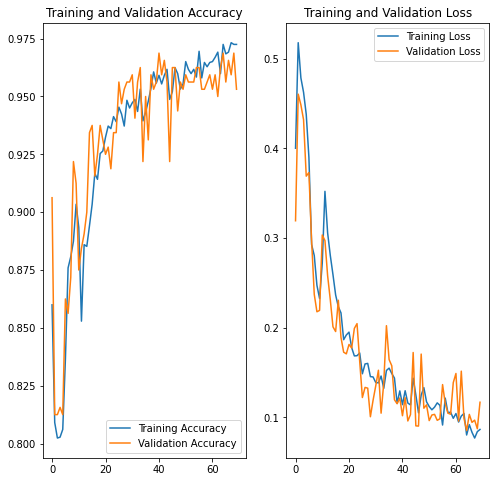

In [ ]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

Run prediction on a sample image

In [ ]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

first image to predict
actual label: Normal
predicted label: Normal


In [ ]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
    possition =12
    first_image = images_batch[possition].numpy().astype('uint8')
    first_label = labels_batch[possition].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[possition])])

first image to predict
actual label: Normal
predicted label: Normal


Write a function for inference

In [ ]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

Now run inference on few sample images

In [ ]:
plt.figure(figsize=(20, 20))
for images, labels in test_ds.take(1):
    for i in range(20):
        ax = plt.subplot(4,5 , i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")

Saving the Model

In [ ]:
model.save("D:/data science project/New folder/model/zulfiker's model.h5")

In [ ]:
model.save('my_model.h5')